EE488 Exercise #2: MNIST Feed-Forward Neural Network
====
TA : JongSuk Kim

TA's E-mail : jskpop@kaist.ac.kr
## Instruction
- In this practice, we will use fully connected layer for classifying MNIST dataset
- Also, we will use convolution neural net for training Flower Dataset Classifier

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Exercise 2]" in the subject for all questions regarding this practice


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T 
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils import data

## Initilaize Data Loader

In [8]:
root='./data'
batch_size=32
# Use Mnist data for training

mnist_train = vision_dsets.MNIST(root = root,  
                                train = True,  
                                transform = T.ToTensor(),
                                download = True) 
mnist_test = vision_dsets.MNIST(root = root,
                                train = False, 
                                transform = T.ToTensor(),
                                download = True)

trainDataLoader = data.DataLoader(dataset = mnist_train,  
                                    batch_size = batch_size, 
                                    shuffle =True, 
                                    num_workers = 1) 

testDataLoader = data.DataLoader(dataset = mnist_test, 
                                batch_size = batch_size,
                                shuffle = False, 
                                num_workers = 1) 


## Define Trainer

In [9]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):

        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1, log_freq = 500):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, (inputs, labels) in enumerate(self.trainloader, 0): 
                #put data on gpu
                inputs = inputs.cuda()
                labels = labels.cuda()
                self.optimizer.zero_grad()    

                #forward
                outputs = self.net(inputs) 

                #compute loss
                loss = self.criterion(outputs, labels) 

                #loss backward and update parameter
                loss.backward() 
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i+1) % log_freq == 0:   
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / log_freq))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() 

        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:

            #put data on gpu
            inputs = inputs.cuda()
            labels = labels.cuda() 

            #forward
            output = self.net(inputs) #batchz_size, class_num

            #make prediction
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))

### (1) 2-Layer Network + Sigmoid + SGD

- Input: (28 * 28)
- Hidden dimension
- Output dimension: 10
- Activation function: sigmoid([docs](https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html?highlight=torch%20functional%20sigmoid#torch.nn.functional.sigmoid)) / relu([docs](https://pytorch.org/docs/1.11/generated/torch.nn.functional.relu.html)) - **Activation function is applied only to the hidden layer.**
- Optimizer: SGD([docs](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))
- Loss: Cross-Entropy([docs](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))

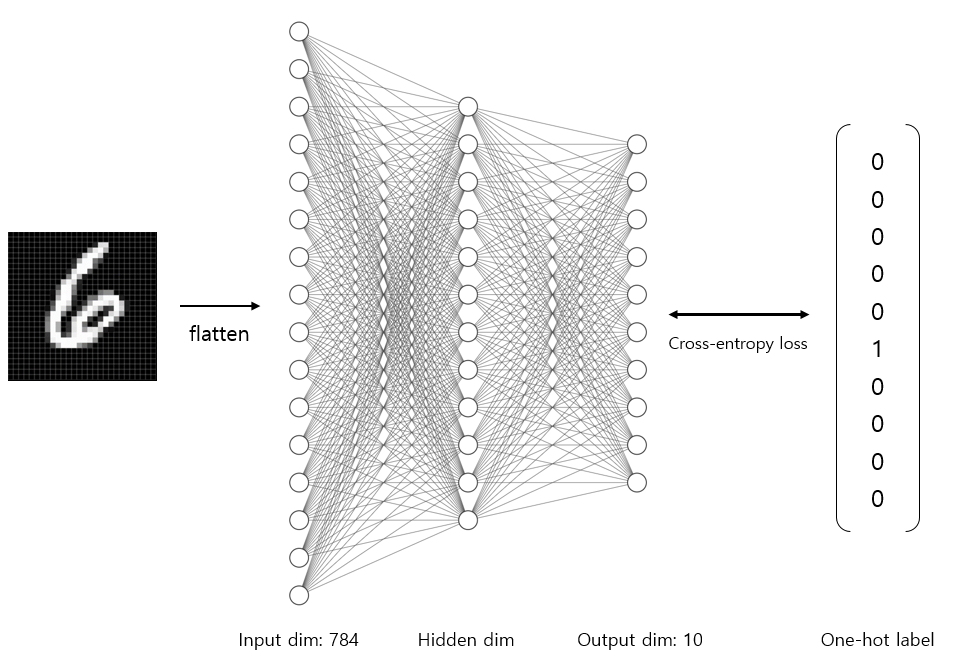

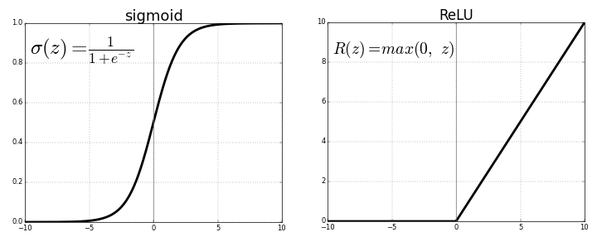

In [10]:
class MNIST_Net(nn.Module): 
    def __init__(self, hidden_dim):
        super(MNIST_Net, self).__init__() 
        self.fc0 = nn.Linear(28*28, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        # convert data to 1-dimension
        x = x.view(-1, 28*28) #batch_size, 28*28-> batch_size, 784

        # first hidden layer
        x = self.fc0(x)

        # activation function
        x = F.sigmoid(x)

        # second hidden layer
        x = self.fc1(x)
        
        return x

In [11]:
# neural net
mnist_net = MNIST_Net(hidden_dim = 50).cuda() 

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [12]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [13]:
trainer.train(epoch = 3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   500] loss: 2.322
[1,  1000] loss: 2.291
[1,  1500] loss: 2.276
[2,   500] loss: 2.252
[2,  1000] loss: 2.238
[2,  1500] loss: 2.226
[3,   500] loss: 2.201
[3,  1000] loss: 2.183
[3,  1500] loss: 2.168
Finished Training


In [14]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set:  Accuracy: 4899/10000 (49%)



### (2) **Practice**: **3-Layer Network** + ReLU + **Adam**

- Input: (28 * 28)
- First hidden dimension: 50
- Second hidden dimension: 30
- Output dimension: 10
- Activation function: ReLU
- Optimizer: Adam
- Loss: Cross-Entropy

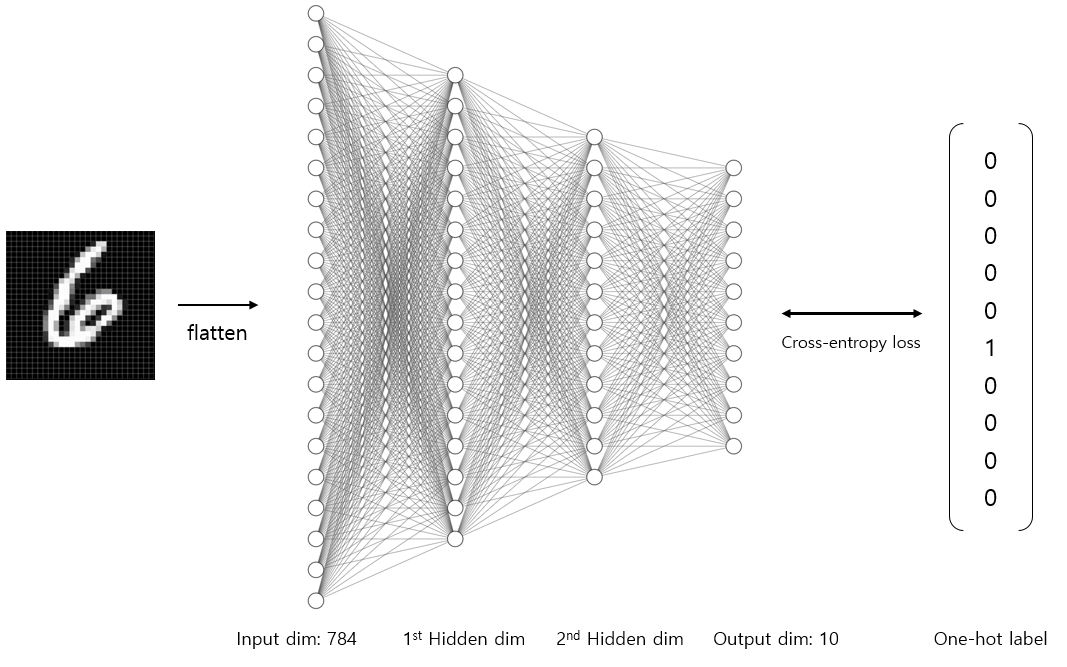

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self, hidden1, hidden2):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,hidden1) 
        self.fc1 = nn.Linear(hidden1, hidden2)
        self.fc2 = nn.Linear(hidden2, 10)

    def forward(self, x):
        # convert data to 1-dimension
        x = x.view(-1, 28*28)

        # first hidden layer
        x = self.fc0(x) #bs, 784 -> bs, hidden1

        # activation function
        x = F.relu(x) #bs, hidden1 -> bs, hidden1

        # second hidden layer
        x = self.fc1(x) #bs, hidden1 -> bs, hidden2

        # activation function
        x = F.relu(x) #bs, hidden2 -> bs, hidden2
        
        # third hidden layer
        x = self.fc2(x) #bs, hidden2->bs, 10

        return x

In [ ]:
# neural net
mnist_net = MNIST_Net(hidden1 = 50, hidden2 = 30).cuda() 

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 3)

[1,   500] loss: 0.624
[1,  1000] loss: 0.304
[1,  1500] loss: 0.269
[2,   500] loss: 0.214
[2,  1000] loss: 0.186
[2,  1500] loss: 0.177
[3,   500] loss: 0.148
[3,  1000] loss: 0.141
[3,  1500] loss: 0.133
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9614/10000 (96%)



### (3) **Practice**: 3-Layer Network + ReLU + Adam + **Batch-Norm**

- Input: (28 * 28)
- First hidden dimension: 50
- Second hidden dimension: 30
- Output dimension: 10
- Activation function: ReLU
- Normalization: Batch normalization([docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html))
- Optimizer: Adam
- Loss: Cross-Entropy

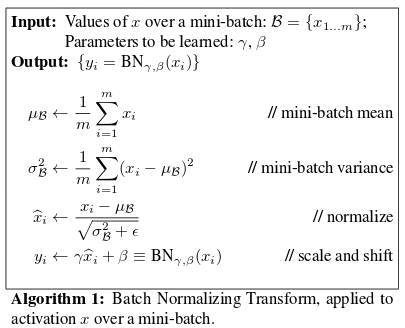

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self, hidden1, hidden2):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,hidden1) 
        self.bn0 = nn.BatchNorm1d(hidden1) 
        self.fc1 = nn.Linear(hidden1, hidden2) 
        self.bn1 = nn.BatchNorm1d(hidden2) 
        self.fc2 = nn.Linear(hidden2, 10) 

    def forward(self, x):
        # convert data to 1-dimension
        x = x.view(-1, 28*28)

        # first hidden layer
        x = self.fc0(x)

        # batch normalization
        x = self.bn0(x)

        # activation function
        x = F.relu(x)

        # second hidden layer
        x = self.fc1(x)

        # batch normalization
        x = self.bn1(x)

        # activation function
        x = F.relu(x)
        
        # third hidden layer
        x = self.fc2(x)
        
        return x

In [ ]:
# neural net
mnist_net = MNIST_Net(hidden1 = 50, hidden2 = 30).cuda() 

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 1)

[1,   500] loss: 0.647
[1,  1000] loss: 0.257
[1,  1500] loss: 0.214
Finished Training


In [ ]:
trainer.test()


Test set:  Accuracy: 9592/10000 (96%)



## Let's use Convolution Layer 

Use Convolution Neural Network([docs](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) for training Flower Dataset classifier

Before designing the model, let's use the custom dataset classifier used in Week1 exercise.

Here, the dataset will be used separately for training and validation. 8 of the 80 images of each class will be used for validation, and if the remainder divided by 80 is bigger than 72, use it for validation and other training purposes.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set data folder path in your google drive 
root_path = '/content/drive/MyDrive/AIcapstone/Week1'

# set image folder and segmentation map folder path
image_path = os.path.join(root_path, 'jpg')
segmap_path = os.path.join(root_path, 'trimaps')

# check image nums for each directory
print(len(os.listdir(image_path)))
print(len(os.listdir(segmap_path)))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


1362
849


In [ ]:
from PIL import Image
import torch
from torchvision import transforms

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class CustomFlowerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, val = True):
        self.root = root
        self.transform = transform
        self.image_list = []
        self.labels = []
        for idx in range(1360):
            image_name = 'image_' + str(idx+1).zfill(4) +".jpg"
            # append image for validation
            if val and (idx%80)>=72: 
                self.image_list.append(image_name)
                self.labels.append(idx//80)
            
            # append image for training
            if not val and (idx%80)<72:
                self.image_list.append(image_name)
                self.labels.append(idx//80)
    
    def __getitem__(self, i):
        image_path = os.path.join(self.root, 'jpg', self.image_list[i])
        image = pil_loader(image_path)
        image = self.transform(image)
        label = self.labels[i]
        return image, label
    
    def __len__(self):
        return len(self.image_list)

In [ ]:
train_transform = transforms.Compose([
            transforms.RandomResizedCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
test_transform = transforms.Compose([
            transforms.CenterCrop(64),
            transforms.ToTensor(),
        ])
train_dataset = CustomFlowerDataset(root_path,train_transform, val=False)
print(len(train_dataset))
test_dataset = CustomFlowerDataset(root_path, train_transform, val=True)
print(len(test_dataset))

1224
136


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle=False)

### Design Flower Dataset Classifier as below Image

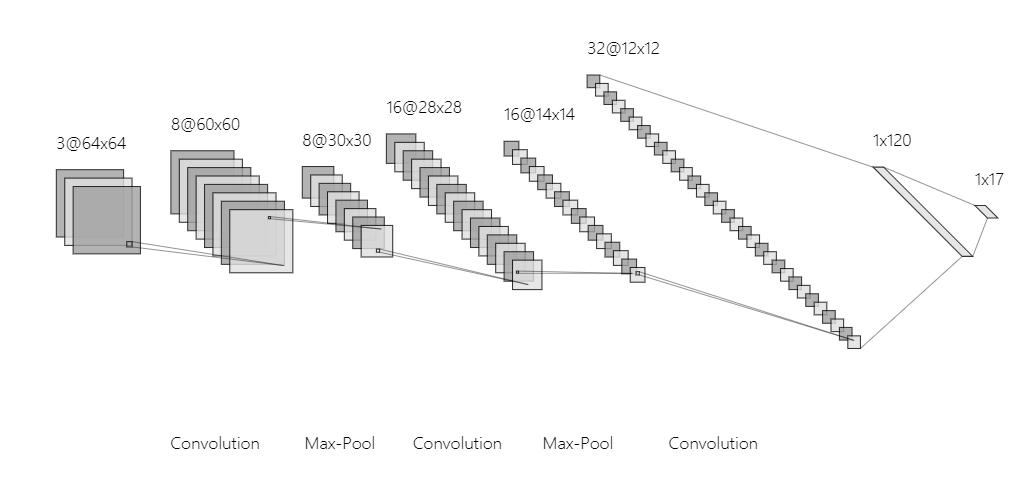

In [ ]:
class FlowerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5) #bs (3,64,64)->(8,60,60)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2) #bs (8,60,60)->(8,30,30)
        self.conv2 = nn.Conv2d(8, 16, 3) #bs (8,30,30)->(16,28,28)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,3) #bs (16,14,14)->(32,12,12)
        self.fc1 = nn.Linear(32*12*12, 120)
        self.fc2 = nn.Linear(120,17)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
flower_net = FlowerNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_net.parameters(), lr=0.001) 

In [ ]:
trainer = Trainer(trainloader = train_loader,
                  testloader = test_loader,
                  net = flower_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 5, log_freq=30)
trainer.test()

[1,    30] loss: 2.519
[1,    60] loss: 2.110
[2,    30] loss: 1.916
[2,    60] loss: 1.959
[3,    30] loss: 1.808
[3,    60] loss: 1.731
[4,    30] loss: 1.714
[4,    60] loss: 1.811
[5,    30] loss: 1.721
[5,    60] loss: 1.621
Finished Training

Test set:  Accuracy: 48/136 (35%)

